In [1]:
import numpy as np
from scipy.stats import gamma
import scipy.interpolate as interpolate
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import matplotlib.animation as animation

In [2]:
%matplotlib notebook

In [3]:
lamb = 10 #The Poisson rate lambda value
num_jolts = 20

In [4]:
rg = np.random.default_rng()
jt = rg.exponential(lamb, num_jolts) #The time points where the Gamma jolts start (but the initial one is at zero)

In [5]:
print(jt) #Shows the random intervals of time

[ 4.32499015  8.55667424 21.92778148 14.91584234  3.79537151  0.24666994
  5.42388724 31.37665931  6.60500914  3.80976789 27.2087031   1.06499799
  0.93157572  5.31829998 10.13353649 17.73647543  9.76820515  7.99846048
  0.92105478 10.7919447 ]


In [6]:
L1 = 3 #length of the suspension spring at equilibrium (m)
Dt = 3 #Diameter of the tire acting as a second spring (at equilibrium) (m)
m2 = 2 #Mass of quarter car = unsprung mass (kg)
m1 = 1 #Mass of wheel + suspension components = sprung mass (kg)
b = 0.75 #Damping coefficient (Ns/m)
Ks = 1 #Spring constant (N/m)
K1 = 2 #Tire 'spring' constant (N/m)
n = 100 #Number of evaluation points between jolts

In [7]:
class Slopy:
    
    def __init__(self, shape, rate, t_init, t_fini, state0):
        self.shape = shape
        self.rate = rate
        self.ti = t_init
        self.tf = t_fini
        self.s0 = state0
        
        
    def set_param(self, shape, rate, t_init, t_fini, state0):
        self.shape = shape
        self.rate = rate
        self.ti = t_init
        self.tf = t_fini
        self.s0 = state0

    def der_state(self, t, state):
        der = np.zeros_like(state)
        der[0] = state[1] # y' = v
        der[1] = (Ks/m2)*state[2] + (b/m2)*state[3] - (Ks/m2)*state[0] - (b/m2)*state[1] + gamma.pdf(t, self.shape, self.ti, self.rate)
        der[2] = state[3] # x' = w
        der[3] = (Ks/m1)*state[0] + (b/m1)*state[1] + (K1/m1)*state[4] - ((Ks+K1)/m1)*state[2] - (b/m1)*state[3] + gamma.pdf(t, self.shape, self.ti, self.rate)
        der[4] = state[4] # u variable
        return der
    
    def solo(self):
        sol = integrate.solve_ivp(self.der_state, (self.ti, self.tf), self.s0, t_eval=T)
        return sol
    
    def forcer(self, t):
        jolt = gamma.pdf(t, self.shape, self.ti, self.rate)
        return jolt

In [8]:
def spring(a,b,pos):
    A = 1/2
    waves = 8
    dy = b-a
    Y = np.linspace(0,dy,200)
    X = A*np.sin(waves/dy*2*np.pi*Y)+pos
    
    return [X,Y+a]

In [9]:
state0 = ([0, 0, 0, 0, 0]) #This is the initial state

In [10]:
for i in range(num_jolts):
    shape = rg.uniform(1, 6)
    rate = rg.uniform(0.2, 6)
    if i == 0:
        ti = 0
        tf = jt[0]
        sloper = Slopy(shape,rate,ti,tf,state0) 
    else:
        ti = tf
        tf = ti + jt[i]
        sloper.set_param(shape,rate,ti,tf,state0)
    dt = (tf-ti)/n
    T = np.linspace(ti, tf, n+1)
    
    sol = sloper.solo()
    state0 = [sol.y[0][-1], sol.y[1][-1], sol.y[2][-1], sol.y[3][-1], sol.y[4][-1]]
    drive = sloper.forcer(T)
    
    if i == 0:
        position = sol.y[0]
        time_grid = sol.t
        force = drive
    else:
        position = np.concatenate((position, sol.y[0][1:]), axis=0)
        time_grid = np.concatenate((time_grid, sol.t[1:]), axis=0)
        force = np.concatenate((force, drive[1:]), axis=0)

<IPython.core.display.Javascript object>


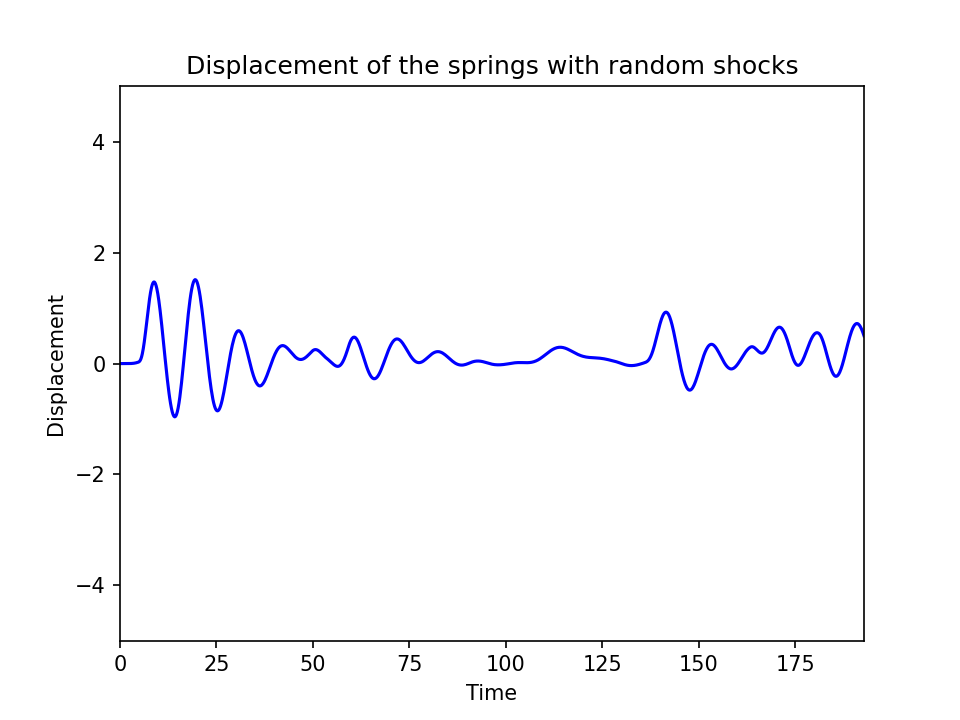

In [11]:
fig0 = plt.figure()
axi = fig0.add_subplot(111, xlim=(0, tf), ylim=(-5, 5))
plt.xlabel("Time")
plt.ylabel("Displacement")
plt.plot(time_grid, position, 'b')
plt.title('Displacement of the springs with random shocks')
plt.show()

<IPython.core.display.Javascript object>


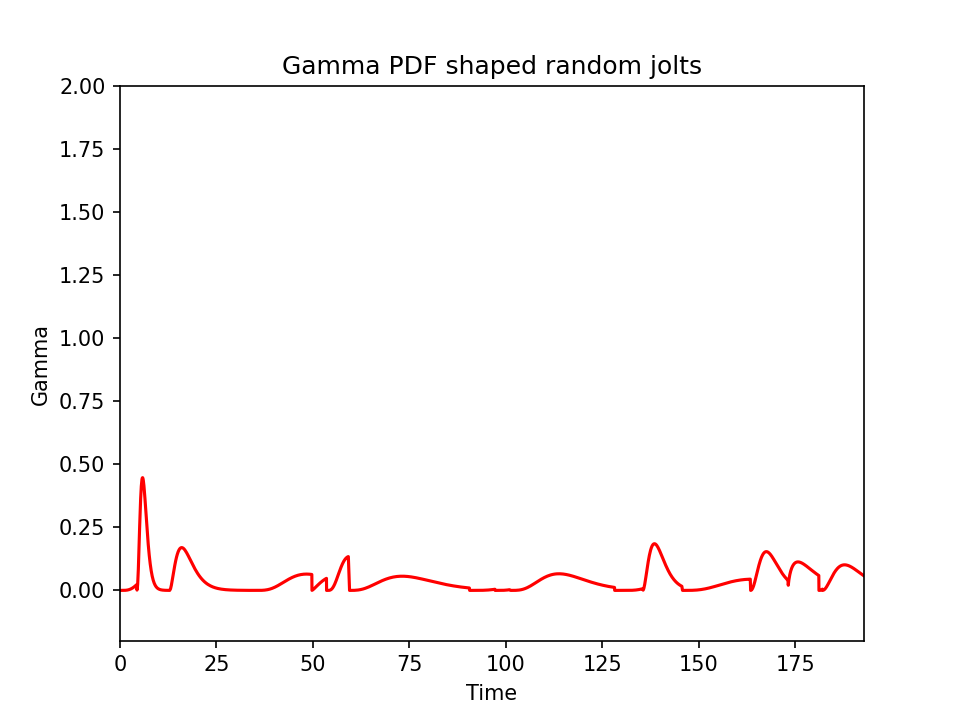

In [12]:
fig0 = plt.figure()
axi = fig0.add_subplot(111, xlim=(0, tf), ylim=(-0.2, 2))
plt.xlabel("Time")
plt.ylabel("Gamma")
plt.plot(time_grid, force, 'r')
plt.title('Gamma PDF shaped random jolts')
plt.show()

In [13]:
# The time grid is not uniform so to show an animation we must interpolate
f = interpolate.interp1d(time_grid, position, kind='cubic')
T_uni = np.linspace(time_grid[0], time_grid[-1], time_grid.size)
pose = f(T_uni)
udt = (time_grid[-1]-time_grid[0])/(time_grid.size-1)

In [14]:
time_grid[-1] #How long the animation will be (s)

192.85590706679898

<IPython.core.display.Javascript object>


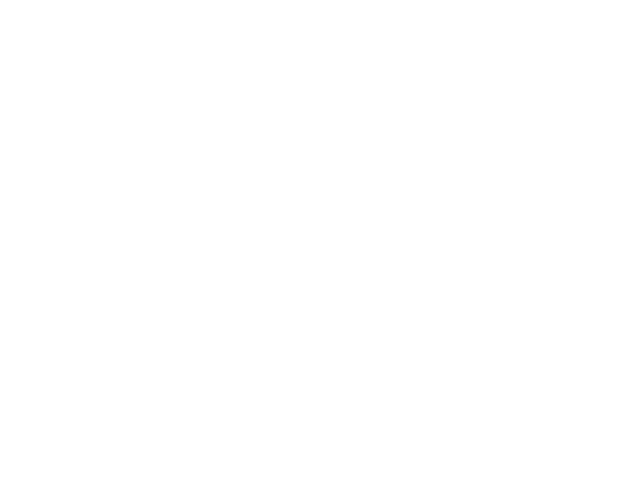

In [15]:
fig = plt.figure()
ax = fig.add_subplot(111,autoscale_on=False, xlim=(-10, 10), ylim=(-Dt-L1-5, Dt+L1+5))
ax.grid()
ax.set_aspect('equal', adjustable='box')

#Road parameters 
X = np.linspace(-10, 10, 500)
Y = np.sin(X/3)

# Initial conditions
spring1, = ax.plot([], [], 'r', lw=1)
springT, = ax.plot([], [], 'g', lw=1)

mass1, = ax.plot([], [],'gs', markersize = 10)
mass2, = ax.plot([], [],'s', color = 'grey', markersize = 14)

wheel, = ax.plot([], [],'bo', markersize = 25)

road, = ax.plot([], [], 'o', color='black', markersize = 2)

time_template = 'time = '
time_text = ax.text(0.04, 0.65, '', transform=ax.transAxes)

title = ax.text(0.2, 0.9, '', transform=ax.transAxes)
    
def init():
    spring1.set_data([], [])
    springT.set_data([], [])
    
    mass1.set_data([], [])
    mass2.set_data([], [])
    
    wheel.set_data([], [])
    
    road.set_data([], [])
    
    time_text.set_text('')
    
    title.set_text('')
    
    return spring1, springT, mass1, mass2, wheel, road, time_text, title


def animate(i):
    
    xpos1 = 0.0
    x1,y1 = spring(L1+Dt, pose[i], xpos1)
    spring1.set_data(x1,y1)
    
    x2,y2 = spring(pose[i], -Dt - pose[i], xpos1)
    springT.set_data(x2,y2)
    
    mass2.set_data(xpos1, L1 + Dt)
    mass1.set_data(xpos1, pose[i])
    
    wheel.set_data(xpos1, -pose[i] - Dt)
    
    road.set_data(X[:i], -1.5*Dt - Y[:i])
    
    time_text.set_text(time_template + '{:4.1f}'.format(i*udt) + 's')
    
    title.set_text("Quarter Car Suspension System")
    
    return spring1, springT, mass1, mass2, wheel, road, time_text, title

ani = animation.FuncAnimation(fig, animate, np.arange(1, len(T_uni)),
                              interval=20, blit=True, init_func=init)

In [ ]:
Writer = animation.writers['ffmpeg']
writer = Writer(fps=24, metadata=dict(artist='Me'), bitrate=1800)
ani.save('animation.mp4', writer=writer, dpi=400)